In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avkrylovv","key":"052e90e6d6225e0650f1e999540f4ec8"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d thedevastator/bank-term-deposit-predictions

  0% 0.00/541k [00:00<?, ?B/s]
100% 541k/541k [00:00<00:00, 103MB/s]


In [8]:
from IPython.display import clear_output
! unzip '/content/bank-term-deposit-predictions.zip' -d '/content/bank-term-deposit'
clear_output()

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [95]:
train = pd.read_csv('/content/bank-term-deposit/train.csv')
test = pd.read_csv('/content/bank-term-deposit/test.csv')

In [96]:
train.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [97]:
train['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [98]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [99]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cats = train.columns[train.dtypes=='object']
for cat in cats:
  le.fit(train[cat])
  le.fit(test[cat])
  train[cat]=le.transform(train[cat])
  test[cat]=le.transform(test[cat])

In [100]:
Y_train = train["y"]
X_train = train.drop(["y"], axis=1)
Y_test = test['y']
X_test = test.drop(['y'], axis=1)

In [101]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T

In [102]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [103]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
      self.data = torch.Tensor(np.array(data)).float()
      self.targets = torch.LongTensor(np.array(targets))
      self.transform = transform

  def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      return x, y

  def __len__(self):
      return len(self.data)

In [104]:
Y_train.value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [153]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=Y_train)
class_weights = np.array([x for x in class_weights], dtype=np.float32)
class_weights[1]=1
class_weights

array([0.5662417, 1.       ], dtype=float32)

In [154]:
train_dataset=MyDataset(X_train, Y_train)
test_dataset=MyDataset(X_test, Y_test)

In [155]:
batch_size=64 # размер пакета

In [156]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True) # загрузчики данных
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [157]:
dataloaders = {"train": train_loader,"validation": test_loader}

In [158]:
class NN_model(nn.Module):
    def __init__(self):
        super(NN_model, self).__init__()
        self.fc1 = nn.Linear(16, 512, bias=False)
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.fc3 = nn.Linear(256, 2)
        self.activation = nn.LeakyReLU(inplace=True)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)


    def forward(self, x):
        # 1-й слой
        x=self.fc1(x)
        x=self.activation(x)
        x=self.bn1(x)
        # 2-й слой
        x=self.fc2(x)
        x=self.activation(x)
        x=self.bn2(x)
        # финальный слой
        x=self.fc3(x)
        return x

In [159]:
model=NN_model()
model.to(device)

NN_model(
  (fc1): Linear(in_features=16, out_features=512, bias=False)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [160]:
! pip install torchinfo

In [161]:
from torchinfo import summary
summary(model,input_size=(1,16))

Layer (type:depth-idx)                   Output Shape              Param #
NN_model                                 [1, 2]                    --
├─Linear: 1-1                            [1, 512]                  8,192
├─LeakyReLU: 1-2                         [1, 512]                  --
├─BatchNorm1d: 1-3                       [1, 512]                  1,024
├─Linear: 1-4                            [1, 256]                  131,072
├─LeakyReLU: 1-5                         [1, 256]                  --
├─BatchNorm1d: 1-6                       [1, 256]                  512
├─Linear: 1-7                            [1, 2]                    514
Total params: 141,314
Trainable params: 141,314
Non-trainable params: 0
Total mult-adds (M): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.57
Estimated Total Size (MB): 0.58

In [162]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))

In [163]:
!pip install pytorch-ignite --quiet

In [164]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [165]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [166]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=2)}

In [167]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [168]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [169]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [170]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [171]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

In [172]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [174]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [175]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [176]:
trainer.run(train_loader, max_epochs=100)

  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 88.81 Сред. ошибка: 0.35920
Результат валидации - Эпоха: 1  Сред. точность: 88.74 Сред. ошибка: 0.35829


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 88.92 Сред. ошибка: 0.35576
Результат валидации - Эпоха: 2  Сред. точность: 89.16 Сред. ошибка: 0.35476


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 88.94 Сред. ошибка: 0.33976
Результат валидации - Эпоха: 3  Сред. точность: 88.83 Сред. ошибка: 0.33391


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 89.33 Сред. ошибка: 0.33415
Результат валидации - Эпоха: 4  Сред. точность: 89.36 Сред. ошибка: 0.33417


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 74.02 Сред. ошибка: 0.61051
Результат валидации - Эпоха: 5  Сред. точность: 72.44 Сред. ошибка: 0.65106


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 89.50 Сред. ошибка: 0.31522
Результат валидации - Эпоха: 6  Сред. точность: 89.29 Сред. ошибка: 0.32456


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 89.21 Сред. ошибка: 0.32897
Результат валидации - Эпоха: 7  Сред. точность: 88.96 Сред. ошибка: 0.33555


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 89.69 Сред. ошибка: 0.31801
Результат валидации - Эпоха: 8  Сред. точность: 89.23 Сред. ошибка: 0.32504


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 89.89 Сред. ошибка: 0.31373
Результат валидации - Эпоха: 9  Сред. точность: 89.45 Сред. ошибка: 0.32118


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 88.42 Сред. ошибка: 0.32047
Результат валидации - Эпоха: 10  Сред. точность: 87.83 Сред. ошибка: 0.33516


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 87.37 Сред. ошибка: 0.32613
Результат валидации - Эпоха: 11  Сред. точность: 86.46 Сред. ошибка: 0.33947


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 88.17 Сред. ошибка: 0.32518
Результат валидации - Эпоха: 12  Сред. точность: 86.88 Сред. ошибка: 0.33829


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 89.71 Сред. ошибка: 0.32136
Результат валидации - Эпоха: 13  Сред. точность: 89.71 Сред. ошибка: 0.32504


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 90.05 Сред. ошибка: 0.31298
Результат валидации - Эпоха: 14  Сред. точность: 90.02 Сред. ошибка: 0.31536


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 90.03 Сред. ошибка: 0.31422
Результат валидации - Эпоха: 15  Сред. точность: 89.87 Сред. ошибка: 0.32033


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 89.99 Сред. ошибка: 0.30409
Результат валидации - Эпоха: 16  Сред. точность: 89.60 Сред. ошибка: 0.31180


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 89.91 Сред. ошибка: 0.32950
Результат валидации - Эпоха: 17  Сред. точность: 89.60 Сред. ошибка: 0.33654


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 89.78 Сред. ошибка: 0.30198
Результат валидации - Эпоха: 18  Сред. точность: 89.43 Сред. ошибка: 0.31437


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 89.53 Сред. ошибка: 0.30433
Результат валидации - Эпоха: 19  Сред. точность: 89.23 Сред. ошибка: 0.31285


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 88.05 Сред. ошибка: 0.32112
Результат валидации - Эпоха: 20  Сред. точность: 87.28 Сред. ошибка: 0.33556


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 89.99 Сред. ошибка: 0.30596
Результат валидации - Эпоха: 21  Сред. точность: 89.69 Сред. ошибка: 0.31295


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 88.88 Сред. ошибка: 0.32021
Результат валидации - Эпоха: 22  Сред. точность: 88.06 Сред. ошибка: 0.33466


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 89.85 Сред. ошибка: 0.29939
Результат валидации - Эпоха: 23  Сред. точность: 89.47 Сред. ошибка: 0.31023


  0%|          | 1/707 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 90.10 Сред. ошибка: 0.30515


2023-12-17 23:12:36,562 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации - Эпоха: 24  Сред. точность: 89.94 Сред. ошибка: 0.31485


2023-12-17 23:12:36,924 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 'MyDataset' object has no attribute 'classes'


State:
	iteration: 16968
	epoch: 24
	epoch_length: 707
	max_epochs: 100
	output: 0.24839206039905548
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

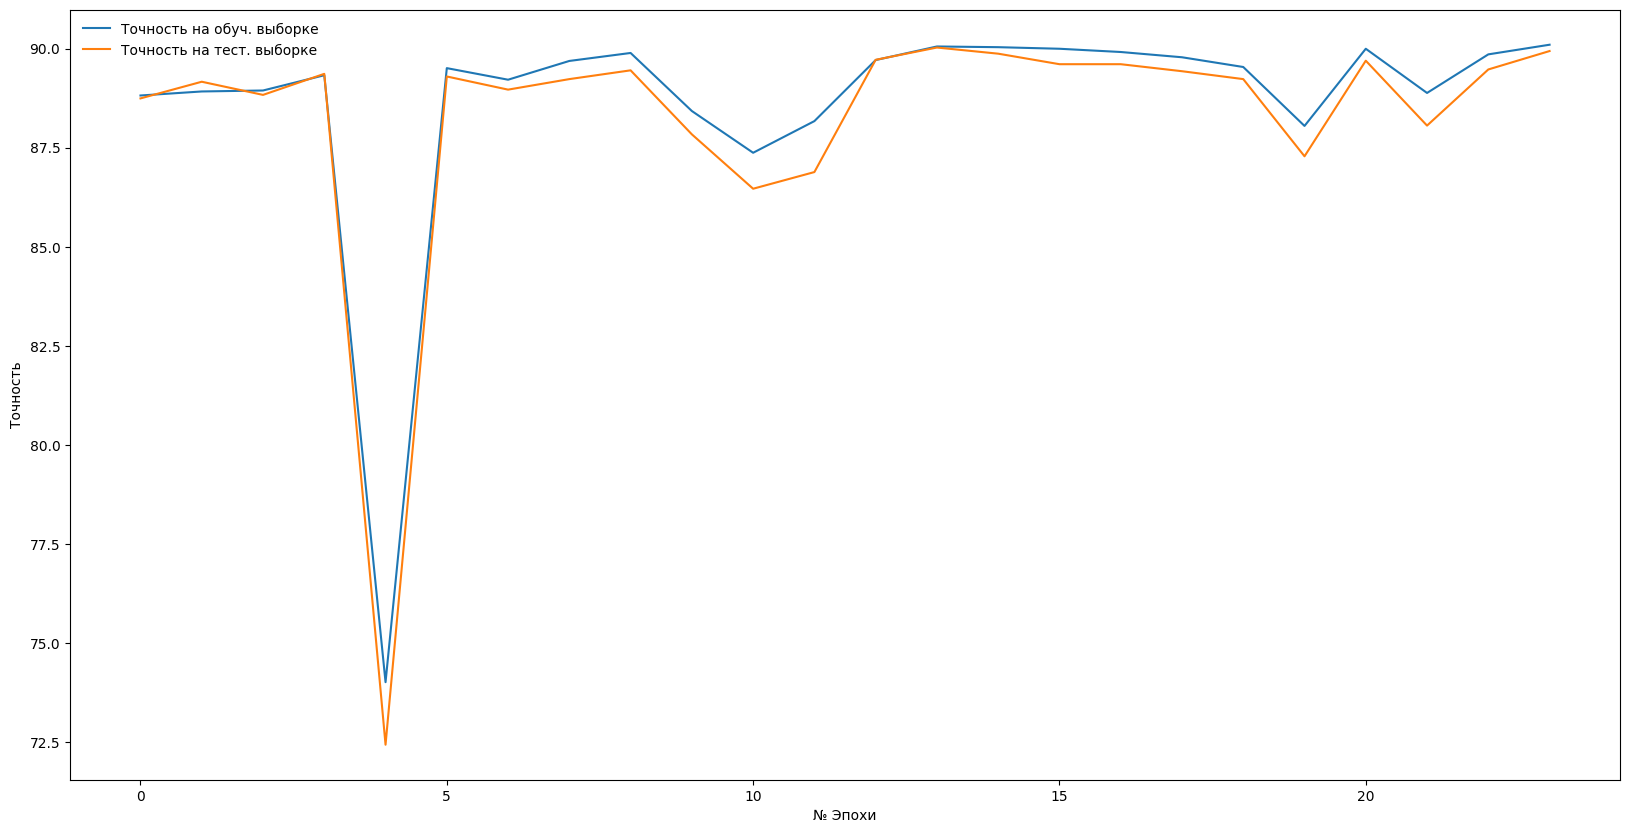

In [177]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

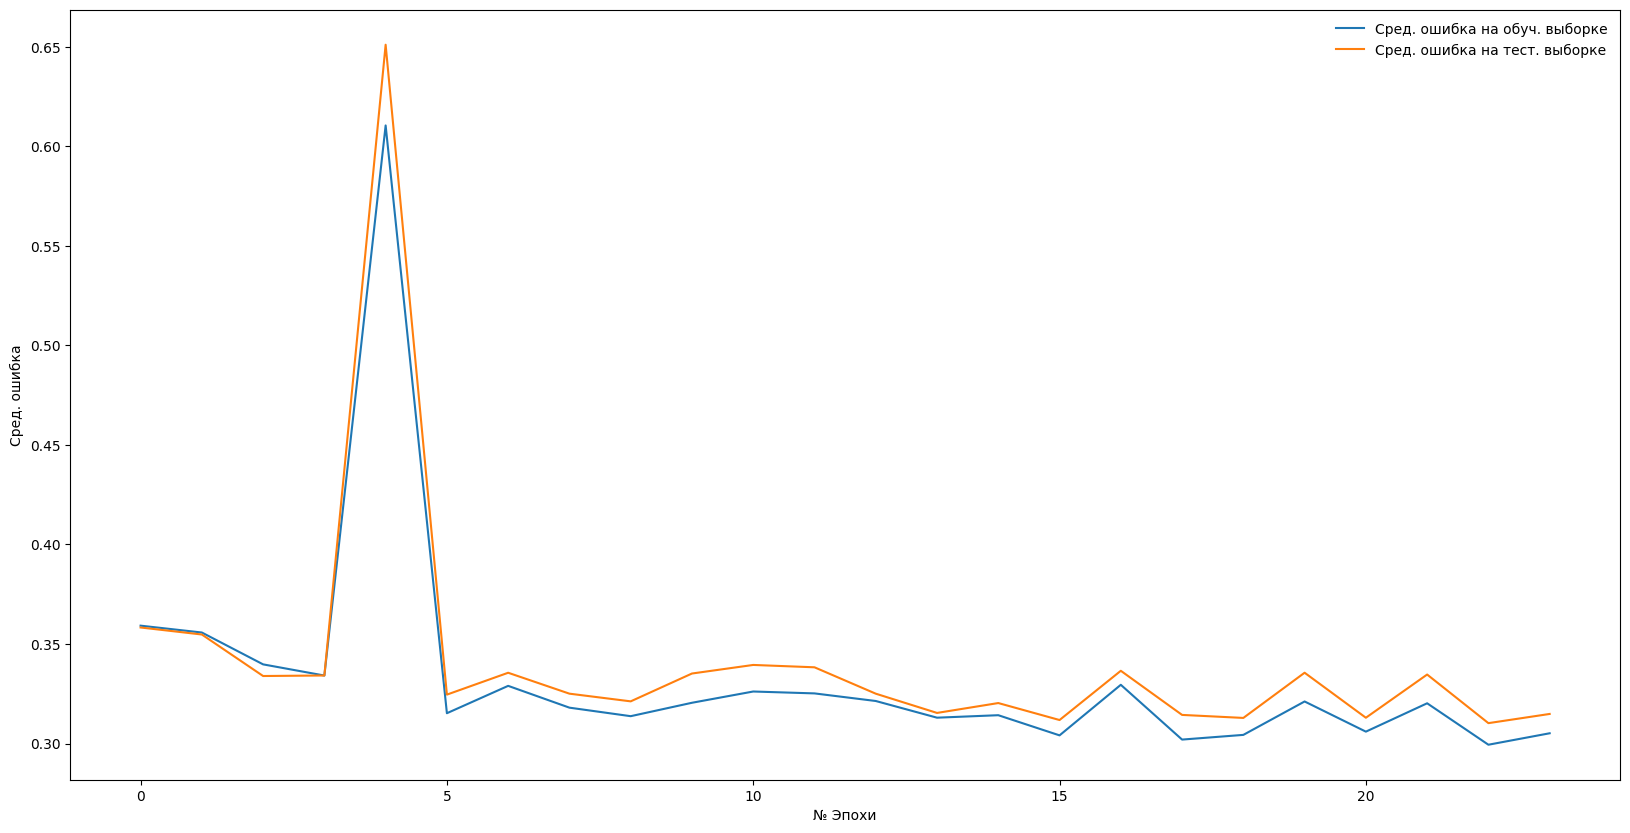

In [178]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['loss'],label="Сред. ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
plt.show()

In [179]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


In [180]:
preds=[]
trgts=[]
with torch.no_grad():
  for data in tqdm(test_loader):
    inputs, targets=data[0].to(device),data[1].to(device)
    outputs=model(inputs)
    targets=targets.to('cpu').numpy()
    pred = outputs.data.max(1, keepdim=True)[1]
    pred = pred.to('cpu').numpy()
    trgts.append(targets)
    preds.append(pred)

  0%|          | 0/71 [00:00<?, ?it/s]

In [181]:
targets=[x for sub in trgts for x in sub]
predictions=[x[0] for sub in preds for x in sub]
targets=np.array(targets)
predictions=np.array(predictions)

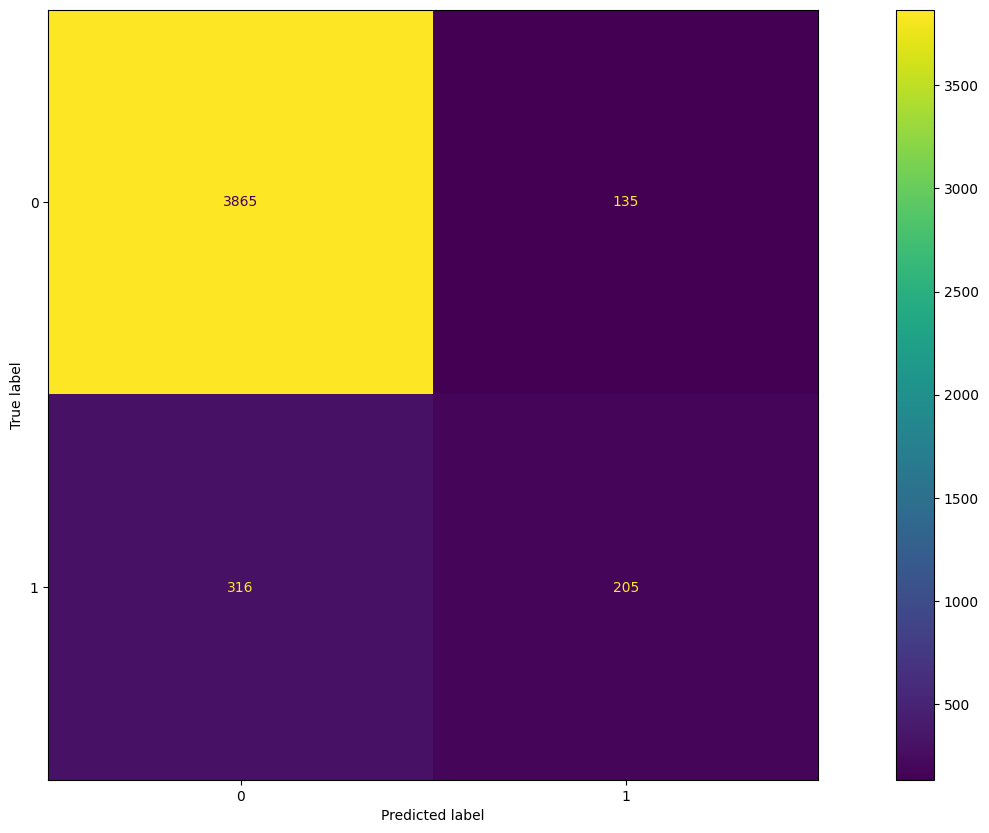

In [182]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
cm = confusion_matrix(targets, predictions)
ConfusionMatrixDisplay(cm).plot()

In [183]:
f1_score(targets, predictions,average='micro')

0.9002433090024331